<a href="https://colab.research.google.com/github/kohathyli/AI-and-Big-Data-in-Quantitative-Trading/blob/main/Deep_Learning_LSTM2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
!pip install hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

from numpy.random import seed
seed(1)
from tensorflow import random

random.set_seed(2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.6 MB/s eta 0:00:00


In [2]:
%pip install "iexfinance"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 1.1 MB/s eta 0:00:00


In [3]:
from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data

In [4]:
start = '2005-01-01'

In [5]:
df_dj = yf.download('^DJI', start=start)[['Close', 'High', 'Low', 'Open', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


In [6]:
df_dj['changePercent'] = df_dj['Close'].diff()

In [7]:
df_dj = df_dj.dropna()
df_dj.columns = [str(x).lower().replace(' ', '_') for x in df_dj.columns]

display(df_dj.head())
display(df_dj.tail())

,close,high,low,open,volume,changepercent
Date,,,,,,
2005-01-04,10630.780273,10769.559570,10605.150391,10727.809570,293280000,-98.649414
2005-01-05,10597.830078,10684.429688,10597.750000,10629.530273,263550000,-32.950195
2005-01-06,10622.879883,10667.580078,10589.330078,10593.190430,232850000,25.049805
2005-01-07,10603.959961,10653.250000,10571.740234,10624.799805,283770000,-18.919922
2005-01-10,10621.030273,10663.740234,10582.379883,10603.440430,279500000,17.070312


,close,high,low,open,volume,changepercent
Date,,,,,,
2023-11-30,35950.890625,35970.699219,35592.218750,35596.570312,435540000,520.468750
2023-12-01,36245.500000,36264.851562,35914.449219,35914.449219,321840000,294.609375
2023-12-04,36204.441406,36238.179688,36029.691406,36089.378906,329450000,-41.058594
2023-12-05,36124.558594,36164.679688,36010.851562,36135.648438,309250000,-79.882812
2023-12-06,36054.429688,36292.578125,36024.250000,36183.730469,283240000,-70.128906


In [8]:
df_dj['daily_ret'] = 100.0 * ((df_dj['close'] / df_dj['close'].shift(1)) - 1)
df_dj.reset_index()

<ipython-input-8-ac68bcdf7f1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dj['daily_ret'] = 100.0 * ((df_dj['close'] / df_dj['close'].shift(1)) - 1)


,Date,close,high,low,open,volume,changepercent,daily_ret
0,2005-01-04,10630.780273,10769.559570,10605.150391,10727.809570,293280000,-98.649414,NaN
1,2005-01-05,10597.830078,10684.429688,10597.750000,10629.530273,263550000,-32.950195,-0.309951
2,2005-01-06,10622.879883,10667.580078,10589.330078,10593.190430,232850000,25.049805,0.236367
3,2005-01-07,10603.959961,10653.250000,10571.740234,10624.799805,283770000,-18.919922,-0.178105
4,2005-01-10,10621.030273,10663.740234,10582.379883,10603.440430,279500000,17.070312,0.160981
...,...,...,...,...,...,...,...,...
4759,2023-11-30,35950.890625,35970.699219,35592.218750,35596.570312,435540000,520.468750,1.468988
4760,2023-12-01,36245.500000,36264.851562,35914.449219,35914.449219,321840000,294.609375,0.819477
4761,2023-12-04,36204.441406,36238.179688,36029.691406,36089.378906,329450000,-41.058594,-0.113279
4762,2023-12-05,36124.558594,36164.679688,36010.851562,36135.648438,309250000,-79.882812,-0.220644


In [9]:
short_window = 10
long_window = 90

In [10]:
df_dj["SMA10"] = df_dj["close"].rolling(window=short_window).mean()
df_dj["SMA90"] = df_dj["close"].rolling(window=long_window).mean()

display(df_dj.head())
display(df_dj.tail())

,close,high,low,open,volume,changepercent,daily_ret,SMA10,SMA90
Date,,,,,,,,,
2005-01-04,10630.780273,10769.559570,10605.150391,10727.809570,293280000,-98.649414,NaN,NaN,NaN
2005-01-05,10597.830078,10684.429688,10597.750000,10629.530273,263550000,-32.950195,-0.309951,NaN,NaN
2005-01-06,10622.879883,10667.580078,10589.330078,10593.190430,232850000,25.049805,0.236367,NaN,NaN
2005-01-07,10603.959961,10653.250000,10571.740234,10624.799805,283770000,-18.919922,-0.178105,NaN,NaN
2005-01-10,10621.030273,10663.740234,10582.379883,10603.440430,279500000,17.070312,0.160981,NaN,NaN


,close,high,low,open,volume,changepercent,daily_ret,SMA10,SMA90
Date,,,,,,,,,
2023-11-30,35950.890625,35970.699219,35592.218750,35596.570312,435540000,520.468750,1.468988,35292.701953,34358.644097
2023-12-01,36245.500000,36264.851562,35914.449219,35914.449219,321840000,294.609375,0.819477,35422.705078,34366.703863
2023-12-04,36204.441406,36238.179688,36029.691406,36089.378906,329450000,-41.058594,-0.113279,35548.421094,34376.945226
2023-12-05,36124.558594,36164.679688,36010.851562,36135.648438,309250000,-79.882812,-0.220644,35645.773047,34384.337109
2023-12-06,36054.429688,36292.578125,36024.250000,36183.730469,283240000,-70.128906,-0.194131,35742.387109,34389.835981


In [11]:
df_dj["Signal"] = 0.0

In [12]:
df_dj["Signal"][short_window:] = np.where(
   df_dj["SMA10"][short_window:] > df_dj["SMA90"][short_window:], 1.0, 0.0)

df_dj.tail(10)

<ipython-input-12-eb92dce4d7c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dj["Signal"][short_window:] = np.where(


,close,high,low,open,volume,changepercent,daily_ret,SMA10,SMA90,Signal
Date,,,,,,,,,,
2023-11-22,35273.031250,35315.199219,35155.800781,35189.328125,237290000,184.742188,0.526507,34773.693359,34345.771658,1.0
2023-11-24,35390.148438,35399.441406,35299.898438,35299.898438,117040000,117.117188,0.332030,34923.514062,34349.426519,1.0
2023-11-27,35333.468750,35410.371094,35280.570312,35376.441406,258340000,-56.679688,-0.160157,35028.550781,34350.629731,1.0
2023-11-28,35416.980469,35518.671875,35307.730469,35332.128906,256210000,83.511719,0.236353,35136.461719,34352.732943,1.0
2023-11-29,35430.421875,35579.128906,35405.890625,35436.800781,299330000,13.441406,0.037952,35196.733984,34352.946094,1.0
2023-11-30,35950.890625,35970.699219,35592.218750,35596.570312,435540000,520.468750,1.468988,35292.701953,34358.644097,1.0
2023-12-01,36245.500000,36264.851562,35914.449219,35914.449219,321840000,294.609375,0.819477,35422.705078,34366.703863,1.0
2023-12-04,36204.441406,36238.179688,36029.691406,36089.378906,329450000,-41.058594,-0.113279,35548.421094,34376.945226,1.0
2023-12-05,36124.558594,36164.679688,36010.851562,36135.648438,309250000,-79.882812,-0.220644,35645.773047,34384.337109,1.0


In [13]:
df_dj["Entry/Exit"] = df_dj["Signal"].diff()

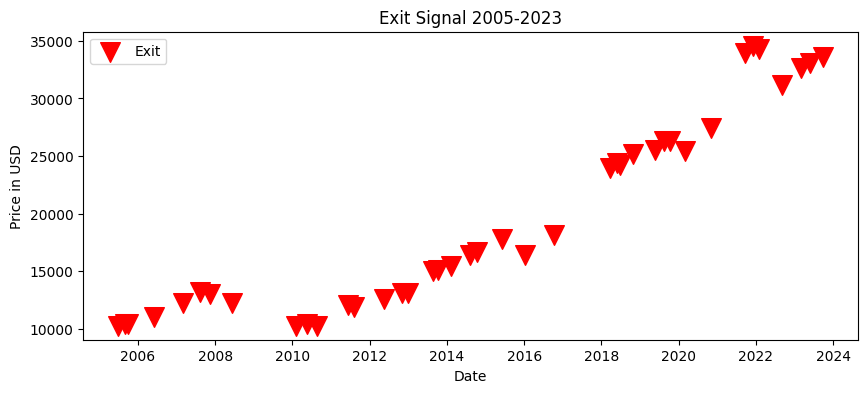

In [21]:
dj_exit = df_dj[df_dj["Entry/Exit"] == -1.0]
exit_signals = df_dj[df_dj["Entry/Exit"] == -1.0]

plt.figure(figsize=(10, 4))
plt.scatter(exit_signals.index, exit_signals["close"], color="red", marker="v", s=200, label="Exit")
plt.title("Exit Signal 2005-2023")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.show()

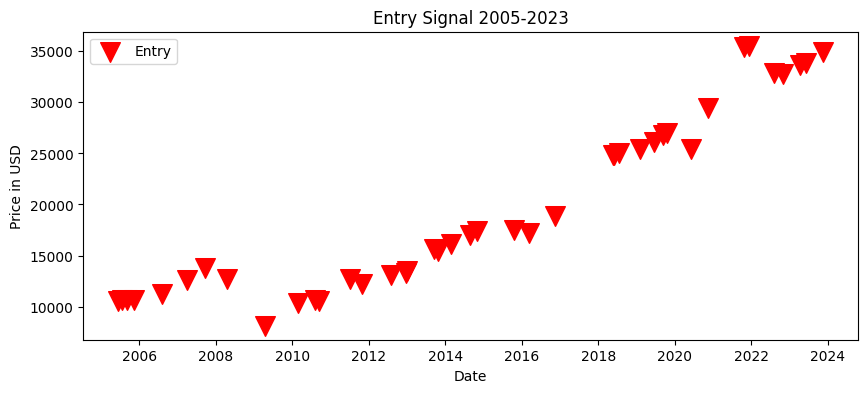

In [22]:
dj_entry = df_dj[df_dj["Entry/Exit"] == 1.0]
entry_signals = df_dj[df_dj["Entry/Exit"] == 1.0]

plt.figure(figsize=(10, 4))
plt.scatter(entry_signals.index, entry_signals["close"], color="red", marker="v", s=200, label="Entry")
plt.title("Entry Signal 2005-2023")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.show()

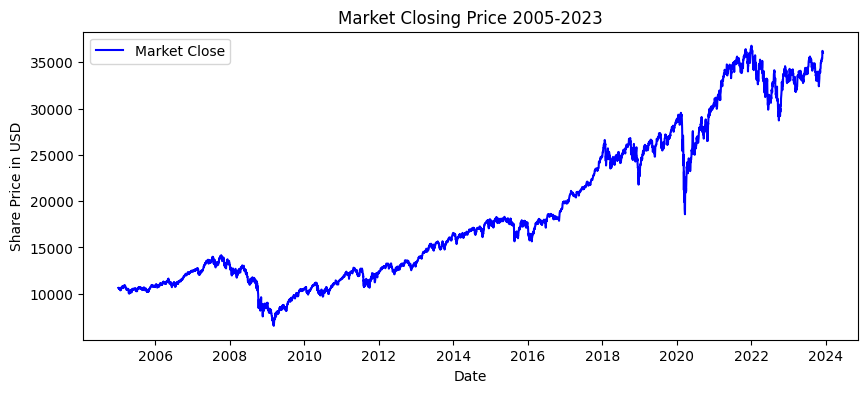

In [23]:
dj_close = df_dj[["close"]]

plt.figure(figsize=(10, 4))
plt.plot(df_dj.index, df_dj["close"], color="blue", label="Market Close")
plt.title("Market Closing Price 2005-2023")
plt.xlabel("Date")
plt.ylabel("Share Price in USD")
plt.legend()
plt.show()

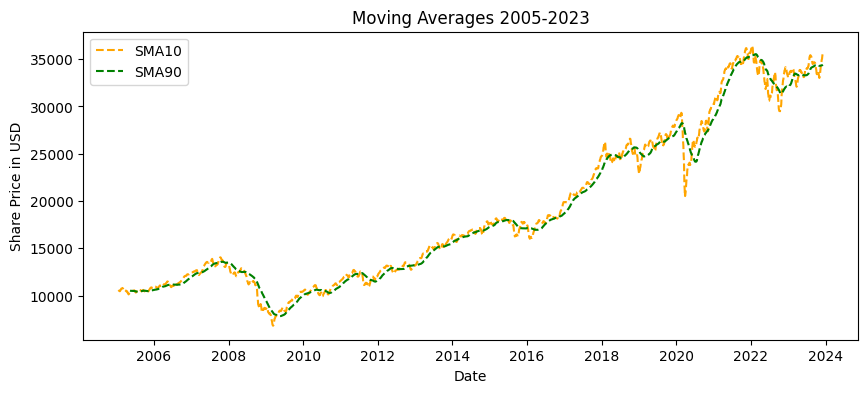

In [24]:
dj_moving_avgs = df_dj[["SMA10", "SMA90"]]

plt.figure(figsize=(10, 4))
plt.plot(df_dj.index, df_dj["SMA10"], label="SMA10", linestyle="--", color="orange")
plt.plot(df_dj.index, df_dj["SMA90"], label="SMA90", linestyle="--", color="green")
plt.title("Moving Averages 2005-2023")
plt.xlabel("Date")
plt.ylabel("Share Price in USD")
plt.legend()
plt.show()

In [18]:
entry_exit_plot = dj_close * dj_moving_avgs * dj_entry * dj_exit

entry_exit_plot.opts(
    title="Dow Jones - SMA10, SMA90, Entry and Exit Points 2005-2023")

NameError: ignored

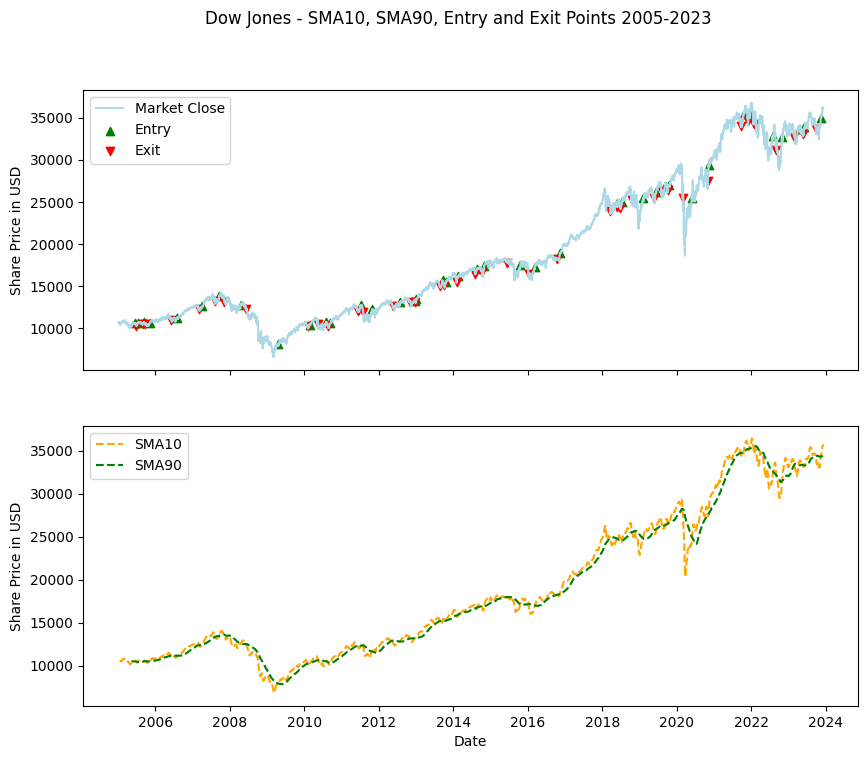

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(df_dj.index, df_dj["close"], color="lightblue", label="Market Close")
ax1.set_ylabel("Share Price in USD")
ax1.legend()

ax2.plot(df_dj.index, df_dj["SMA10"], label="SMA10", linestyle="--", color="orange")
ax2.plot(df_dj.index, df_dj["SMA90"], label="SMA90", linestyle="--", color="green")
ax2.set_xlabel("Date")
ax2.set_ylabel("Share Price in USD")
ax2.legend()

ax1.scatter(df_dj.index[df_dj["Entry/Exit"] == 1.0], df_dj["close"][df_dj["Entry/Exit"] == 1.0], color="green", marker="^", label="Entry")
ax1.scatter(df_dj.index[df_dj["Entry/Exit"] == -1.0], df_dj["close"][df_dj["Entry/Exit"] == -1.0], color="red", marker="v", label="Exit")
ax1.legend()

plt.suptitle("Dow Jones - SMA10, SMA90, Entry and Exit Points 2005-2023")
plt.show()

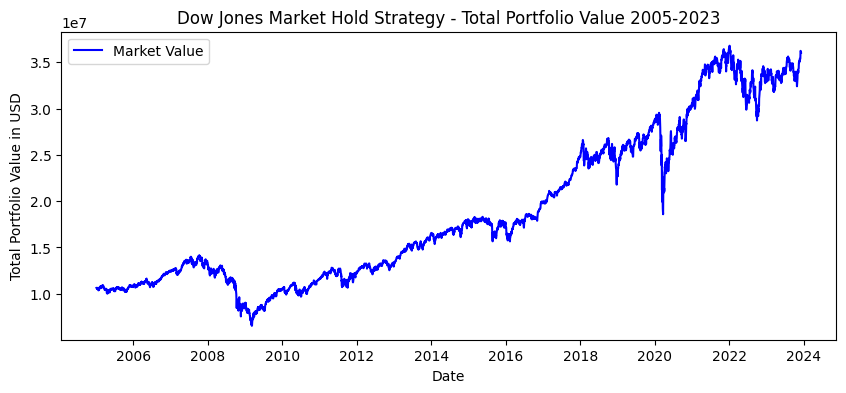

In [26]:
dj_hold_investment = df_dj["close"] * 1000

plt.figure(figsize=(10, 4))
plt.plot(df_dj.index, dj_hold_investment, color="blue", label="Market Value")
plt.title("Dow Jones Market Hold Strategy - Total Portfolio Value 2005-2023")
plt.xlabel("Date")
plt.ylabel("Total Portfolio Value in USD")
plt.legend()
plt.show()

In [27]:
initial_capital = float((df_dj['open'].values[0])*1000)
share_size = 1000

In [28]:
df_dj['Position'] = share_size * df_dj['Signal']

In [29]:
df_dj['Entry/Exit Position'] = df_dj['Position'].diff()

In [30]:
df_dj['Portfolio Holdings'] = df_dj['close'] * df_dj['Position']

In [31]:
df_dj['Portfolio Cash'] = initial_capital - (df_dj['close'] * df_dj['Entry/Exit Position']).cumsum()

In [32]:
df_dj['Portfolio Total'] = df_dj['Portfolio Cash'] + df_dj['Portfolio Holdings']

In [33]:
df_dj['Portfolio Daily Returns'] = df_dj['Portfolio Total'].pct_change()

In [34]:
df_dj['Portfolio Cumulative Returns'] = (1 + df_dj['Portfolio Daily Returns']).cumprod() - 1

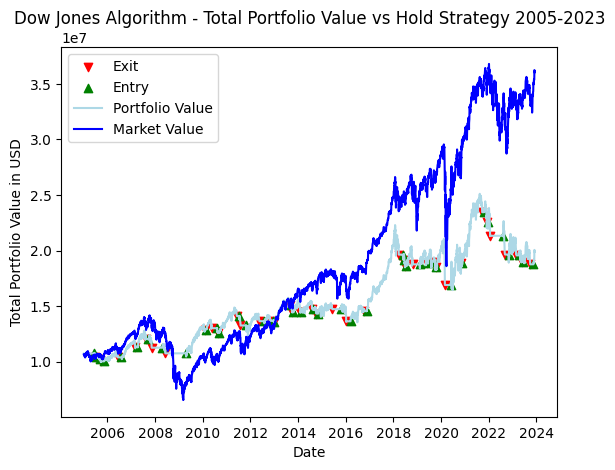

In [35]:
exit_points = df_dj[df_dj['Entry/Exit'] == -1.0]
plt.scatter(exit_points.index, exit_points['Portfolio Total'], color='red', marker='v', label='Exit')

entry_points = df_dj[df_dj['Entry/Exit'] == 1.0]
plt.scatter(entry_points.index, entry_points['Portfolio Total'], color='green', marker='^', label='Entry')

plt.plot(df_dj.index, df_dj['Portfolio Total'], color='lightblue', label='Portfolio Value')

plt.plot(df_dj.index, dj_hold_investment, color='blue', label='Market Value')

plt.title("Dow Jones Algorithm - Total Portfolio Value vs Hold Strategy 2005-2023")
plt.xlabel("Date")
plt.ylabel("Total Portfolio Value in USD")
plt.legend()
plt.show()

In [36]:
df_dj_before_2013 = df_dj[df_dj.index <= '2013-5-31']
df_dj_after_2013 = df_dj[df_dj.index >= '2013-06-01']

In [37]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [38]:
window_size = 5
feature_column = 4
target_column = 4

X, y = window_data(df_dj_before_2013, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[293280000 263550000 232850000 283770000 279500000]
 [263550000 232850000 283770000 279500000 292050000]
 [232850000 283770000 279500000 292050000 293140000]
 [283770000 279500000 292050000 293140000 271180000]
 [279500000 292050000 293140000 271180000 223070000]] 

y sample values:
[[292050000]
 [293140000]
 [271180000]
 [223070000]
 [267680000]]


In [39]:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y_train)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [41]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [42]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [43]:
model = Sequential()

number_units = 10
dropout_fraction = 0.2

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train,epochs=20,batch_size=1)

Epoch 1/20
1477/1477 [==============================] - 13s 5ms/step - loss: 0.0149
Epoch 2/20
1477/1477 [==============================] - 9s 6ms/step - loss: 0.0120
Epoch 3/20
1477/1477 [==============================] - 8s 5ms/step - loss: 0.0110
Epoch 4/20
1477/1477 [==============================] - 8s 5ms/step - loss: 0.0110
Epoch 5/20
1477/1477 [==============================] - 9s 6ms/step - loss: 0.0105
Epoch 6/20
1477/1477 [==============================] - 7s 5ms/step - loss: 0.0101
Epoch 7/20
1477/1477 [==============================] - 10s 6ms/step - loss: 0.0096
Epoch 8/20
1477/1477 [==============================] - 7s 5ms/step - loss: 0.0096
Epoch 9/20
1477/1477 [==============================] - 9s 6ms/step - loss: 0.0095
Epoch 10/20
1477/1477 [==============================] - 8s 5ms/step - loss: 0.0093
Epoch 11/20
1477/1477 [==============================] - 8s 6ms/step - loss: 0.0092
Epoch 12/20
1477/1477 [==============================] - 8s 6ms/step - loss: 0.0091

In [44]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 3ms/step - loss: 0.0077


0.0076684001833200455

In [45]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

20/20 [==============================] - 1s 3ms/step


In [46]:
predicted_stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df_dj_before_2013.index[-len(real_prices): ])
predicted_stocks

,Real,Predicted
Date,,
2010-11-22,152850000.0,220826016.0
2010-11-23,192820000.0,206420752.0
2010-11-24,138280000.0,209751200.0
2010-11-26,68400000.0,195197296.0
2010-11-29,151530000.0,162322192.0
...,...,...
2013-05-24,105660000.0,186441952.0
2013-05-28,130680000.0,171181792.0
2013-05-29,114020000.0,171148720.0


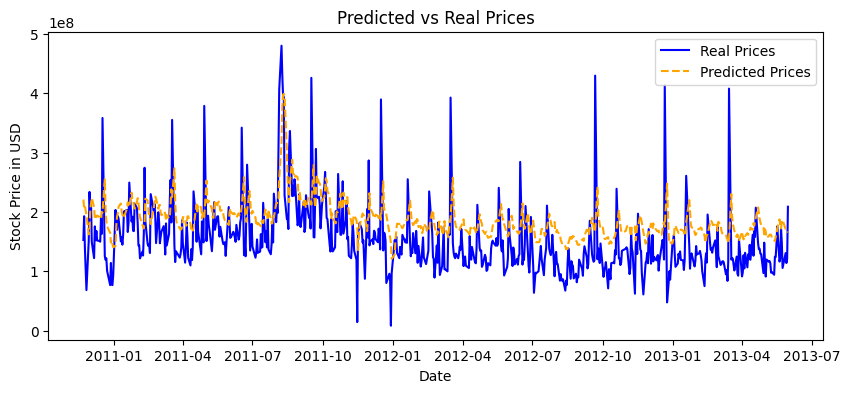

In [64]:
plt.figure(figsize=(10, 4))
plt.plot(predicted_stocks.index, predicted_stocks["Real"], label="Real Prices", linestyle="-", color="blue")
plt.plot(predicted_stocks.index, predicted_stocks["Predicted"], label="Predicted Prices", linestyle="--", color="orange")
plt.title("Predicted vs Real Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price in USD")
plt.legend()
plt.show()

In [48]:
window_size = 5
feature_column = 1
target_column = 1

X, y = window_data(df_dj_after_2013, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X_test = X
y_test = y

X sample values:
[[15254.11035156 15304.98046875 15168.62988281 15040.62011719
  15255.58007812]
 [15304.98046875 15168.62988281 15040.62011719 15255.58007812
  15300.63964844]
 [15168.62988281 15040.62011719 15255.58007812 15300.63964844
  15251.0703125 ]
 [15040.62011719 15255.58007812 15300.63964844 15251.0703125
  15241.28027344]
 [15255.58007812 15300.63964844 15251.0703125  15241.28027344
  15202.26953125]] 

y sample values:
[[15300.63964844]
 [15251.0703125 ]
 [15241.28027344]
 [15202.26953125]
 [15205.91992188]]


In [49]:
scaler = MinMaxScaler()
scaler.fit(X_test)

X_test = scaler.transform(X_test)
scaler.fit(y_test)
y_test = scaler.transform(y_test)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [50]:
model.evaluate(X_test, y_test)

83/83 [==============================] - 0s 4ms/step - loss: 0.0044


0.004409913904964924

In [51]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

83/83 [==============================] - 0s 4ms/step


In [52]:
predicted_stocks_20 = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df_dj_after_2013.index[-len(real_prices): ])
predicted_stocks_20.to_csv('predicted_stocks_2023.csv', index=True, header=True)

In [53]:
predicted_stocks_21 = predicted_stocks_20.copy()
predicted_stocks_21['Change'] = predicted_stocks_21['Predicted'].diff()
predicted_stocks_21['Change_Positive'] = (predicted_stocks_21['Change'] > 0).astype(int)
predicted_stocks_21.drop(columns=['Change'], inplace=True)

In [54]:
predicted_stocks_21['Return'] = predicted_stocks_21['Real'].pct_change()
predicted_stocks_21['Return'] = predicted_stocks_21['Return'] * predicted_stocks_21['Change_Positive']
predicted_stocks_21['cumret'] = (predicted_stocks_21['Return'] + 1).cumprod()-1

In [55]:
predicted_stocks_21

,Real,Predicted,Change_Positive,Return,cumret
Date,,,,,
2013-06-10,15300.639648,17238.216797,0,NaN,NaN
2013-06-11,15251.070312,17274.111328,1,-0.003240,-0.003240
2013-06-12,15241.280273,17280.173828,1,-0.000642,-0.003880
2013-06-13,15202.269531,17279.376953,0,-0.000000,-0.003880
2013-06-14,15205.919922,17270.175781,0,0.000000,-0.003880
...,...,...,...,...,...
2023-11-30,35970.699219,32780.917969,1,0.011006,2.864640
2023-12-01,36264.851562,32909.128906,1,0.008178,2.896243
2023-12-04,36238.179688,33039.269531,1,-0.000735,2.893377


In [65]:
dji = pd.DataFrame(yf.download('^DJI',start='2013-06-23')['Close'])
dji = dji.rename(columns={'Close': 'DJI'})

[*********************100%%**********************]  1 of 1 completed


In [66]:
dji['ret'] = dji['DJI'].pct_change()

In [67]:
dji['cumret'] = (1+dji['ret']).cumprod()-1

In [68]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=predicted_stocks_21.index, y=predicted_stocks_21['cumret'], mode='lines',line=dict(color='purple'), name='deep learning dow jones'))
fig.add_trace(go.Scatter(x=dji.index, y=dji['cumret'], mode='lines',line=dict(color='red'), name='dow jones'))

fig.update_layout(
    title={'text':'Cumulative Performance',
           'y':0.9,
        'x':0.5,
          'xanchor': 'center',
             'yanchor': 'top' },

    xaxis=dict(
        title='',
        #ticksuffix="%",
        #tickprefix=''
    ),

    yaxis=dict(
        title='Returns',
         ticksuffix=""
    ),


    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)



fig

In [83]:
annual_ret = (predicted_stocks_21.loc['2023-12-06', 'cumret'] + 1)**(1/10.5) - 1

In [84]:
annual_ret

0.1383704492154656

In [85]:
annual_sd = np.sqrt(252)*predicted_stocks_21['Return'].std()

In [86]:
annual_sd

0.08559864101609758

In [89]:
rf = 0.005
sharpe_ratio = (annual_ret-rf)/annual_sd

In [90]:
sharpe_ratio

1.558090731725333

In [91]:
import numpy as np
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pandas import to_datetime

In [92]:
start='2013-01-01'

In [93]:
overall = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]

In [94]:
overall.at[11, 'Date added'] = '2013-09-23'
overall.at[10, 'Date added'] = '2019-04-02'

In [95]:
stocks = overall.Symbol.to_list()

In [96]:
overall = overall[overall['Date added'] >= start]

In [97]:
data = {'Date': ['2020-08-31','2020-08-31','2020-08-31','2019-04-02','2018-06-26','2015-03-19','2013-09-23','2013-09-23','2013-09-23'],
      'Company': ['XOM','PFE','RTX','DD','GE','T','AA','BAC','HPQ']}

In [98]:
removed = pd.DataFrame(data)
removed['Date'] = pd.to_datetime(removed['Date'])
removed.set_index('Date', inplace=True)

In [99]:
stocks.extend(removed.Company.to_list())

In [100]:
df_dj1 = yf.download(stocks, start=start)['Close']
df_dj1.index = pd.to_datetime(df_dj1.index)

[*********************100%%**********************]  39 of 39 completed


In [101]:
def pricefilter_rem(ticker):
  df_dj1[ticker] = df_dj1[ticker][df_dj1[ticker].index <= removed[removed.Company == ticker].index[0]]

In [102]:
def pricefilter_add(ticker):
  df_dj1[ticker] = df_dj1[ticker][df_dj1[ticker].index >= overall[overall.Symbol == ticker]['Date added'].values[0]]

In [103]:
for ticker_rem in removed.Company:
  pricefilter_rem(ticker_rem)
for ticker_add in overall.Symbol:
  pricefilter_add(ticker_add)

In [104]:
df_dj_ret = df_dj1.pct_change()

In [105]:
equal_weight = 1/30
equal_ret = (equal_weight * df_dj_ret.iloc[:, 1:]).sum(axis=1).loc['2013-06-23':]
equal_cumret = (1+equal_ret).cumprod()-1

In [106]:
frequency = '2W'
range = 12

In [107]:
ret = (1+df_dj_ret).resample(frequency).prod()

In [108]:
ret_range = ret.rolling(range).apply(np.prod).dropna()

In [109]:
def momentum_strategy(date,n_top,n_bottom,weights):
  all = ret_range.loc[date][ret_range.loc[date] != 1]
  top = all.nlargest(n_top)
  bottom = all.nsmallest(n_bottom)
  middle = all.loc[~(all.isin(top) | all.isin(bottom))]
  top_ret = (ret[top.name:][1:2][top.index]).mean(axis=1).values[0]
  bottom_ret  = (ret[bottom.name:][1:2][bottom.index]).mean(axis=1).values[0]
  middle_ret  = (ret[middle.name:][1:2][middle.index]).mean(axis=1).values[0]
  result = weights[0]*top_ret + weights[1]*middle_ret + weights[2]*bottom_ret
  d = (ret[top.name:][1:2].index).strftime('%Y-%m-%d')[0]
  return result, d

In [110]:
n_top = 5
n_bottom = 5
weights = [1, 0, 0]

In [ ]:
momentum = pd.DataFrame(columns = ['Date', 'ret'])
for date in ret_range.index[:-1]:
  result, d = momentum_strategy(date,n_top,n_bottom,weights)
  momentum = momentum.append({'Date': d,'ret': result}, ignore_index=True)
momentum['Date'] = pd.to_datetime(momentum['Date'])
momentum.set_index('Date', inplace=True)
momentum['cumret'] = momentum['ret'].cumprod()-1

In [112]:
window = 110
annual_sd1 = np.sqrt(252)*df_dj_ret.rolling(window).apply(np.std).dropna(how = 'all')

In [113]:
annual_ret1 = (df_dj_ret+1).rolling(window).apply(np.prod).dropna(how='all')**(252/window) - 1

In [114]:
sharpe_ratio = (annual_ret1-rf)/annual_sd1

In [115]:
date_range_14days = pd.date_range(start=sharpe_ratio.index[0], end=sharpe_ratio.index[-1], freq='14D')
sharpe_ratio = sharpe_ratio[sharpe_ratio.index.isin(date_range_14days)]

In [116]:
w = 10

In [117]:
s_ret = (df_dj_ret+1).rolling(w).apply(np.prod).dropna(how='all')
s_ret = s_ret.loc[sharpe_ratio.index[0]:]

In [118]:
date_range_14days = pd.date_range(start=s_ret.index[0], end=s_ret.index[-1], freq='14D')
s_ret = s_ret[s_ret.index.isin(date_range_14days)]

In [119]:
def sharpe_ratio_strategy(date,n_top,n_bottom,weights):
  all = sharpe_ratio.loc[date][s_ret.loc[date] != 1].dropna()
  top = all.nlargest(n_top)
  bottom = all.nsmallest(n_bottom)
  middle = all.loc[~(all.isin(top) | all.isin(bottom))]
  top_ret = (s_ret[top.name:][1:2][top.index]).mean(axis=1).values[0]
  bottom_ret  = (s_ret[bottom.name:][1:2][bottom.index]).mean(axis=1).values[0]
  middle_ret  = (s_ret[middle.name:][1:2][middle.index]).mean(axis=1).values[0]
  result = weights[0]*top_ret + weights[1]*middle_ret + weights[2]*bottom_ret
  d = (s_ret[top.name:][1:2].index).strftime('%Y-%m-%d')[0]
  return result, d

In [120]:
n_top_0 = 5
n_bottom_0 = 5
weights_0 = [1, 0, 0]

In [ ]:
sr = pd.DataFrame(columns = ['Date', 'ret'])
for date in sharpe_ratio.index[:-1]:
  result, d = sharpe_ratio_strategy(date,n_top_0,n_bottom_0,weights_0)
  sr = sr.append({'Date': d,'ret': result}, ignore_index=True)
sr['Date'] = pd.to_datetime(sr['Date'])
sr.set_index('Date', inplace=True)
sr['cumret'] = sr['ret'].cumprod()-1

In [122]:
window_short_term = 10
window_long_term = 110

In [123]:
moving_average_short_term = df_dj_ret.rolling(window_short_term).apply(np.mean).dropna(how='all')

In [124]:
moving_average_long_term = df_dj_ret.rolling(window_long_term).apply(np.mean).dropna(how='all')

In [125]:
moving_average_short_term = moving_average_short_term.loc[moving_average_long_term.index[0]:]

In [126]:
date_range_14days = pd.date_range(start=moving_average_long_term.index[0], end=moving_average_long_term.index[-1], freq='14D')
moving_average_long_term = moving_average_long_term[moving_average_long_term.index.isin(date_range_14days)]
moving_average_short_term = moving_average_short_term[moving_average_short_term.index.isin(date_range_14days)]

In [127]:
def trend_strategy(date):
  stocks = s_ret.loc[date][moving_average_long_term.columns[moving_average_short_term.loc[date] > moving_average_long_term.loc[date]]]
  result = (s_ret[stocks.name:][1:2][stocks.index]).mean(axis=1).values[0]
  d = (s_ret[stocks.name:][1:2].index).strftime('%Y-%m-%d')[0]
  return result, d

In [ ]:
trend_trading = pd.DataFrame(columns = ['Date', 'ret'])
for date in moving_average_long_term.index[:-1]:
  result, d = trend_strategy(date)
  trend_trading = trend_trading.append({'Date': d,'ret': result}, ignore_index=True)
trend_trading['Date'] = pd.to_datetime(trend_trading['Date'])
trend_trading.set_index('Date', inplace=True)
trend_trading['cumret'] = trend_trading['ret'].cumprod()-1

In [129]:
dji_trend = pd.DataFrame(yf.download('^DJI',start=s_ret.index[0])['Close'])
dji_trend = dji.rename(columns={'Close': 'DJI'})
dji_trend_ret = dji_trend.pct_change()

[*********************100%%**********************]  1 of 1 completed


In [130]:
w_short_term = 10
w_long_term = 110

In [131]:
dji_trend_short_term = dji_trend_ret.rolling(w_short_term).apply(np.mean).dropna()

In [132]:
dji_trend_long_term = dji_trend_ret.rolling(w_long_term).apply(np.mean).dropna()

In [133]:
dji_trend_short_term = dji_trend_short_term.loc[dji_trend_long_term.index[0]:]

In [134]:
date_range_14days = pd.date_range(start=dji_trend_long_term.index[0], end=dji_trend_long_term.index[-1], freq='14D')
dji_trend_long_term = dji_trend_long_term[dji_trend_long_term.index.isin(date_range_14days)]
dji_trend_short_term = dji_trend_short_term[dji_trend_short_term.index.isin(date_range_14days)]

In [135]:
w=10
trend_ret = (df_dj_ret+1).rolling(w).apply(np.prod).dropna(how='all')
trend_ret = trend_ret.loc[dji_trend_long_term.index[0]:]
trend_ret = trend_ret[trend_ret.index.isin(date_range_14days)]

In [136]:
w = 110
trend_ret_m = (df_dj_ret+1).rolling(w).apply(np.prod).dropna(how='all')
trend_ret_m = trend_ret_m.loc[dji_trend_long_term.index[0]:]
trend_ret_m = trend_ret_m[trend_ret_m.index.isin(date_range_14days)]

In [137]:
def trend_strategy_upgrade(date,n_top,n_bottom,weights):
  all = trend_ret_m.loc[date][trend_ret_m.loc[date] != 1].dropna()
  if (dji_trend_short_term.loc[date] > dji_trend_long_term.loc[date]).loc['DJI']:
    all = trend_ret_m.loc[date][trend_ret_m.loc[date] != 1].dropna()
    top = all.nlargest(n_top)
    bottom = all.nsmallest(n_bottom)
    middle = all.loc[~(all.isin(top) | all.isin(bottom))]
    top_ret = (trend_ret[top.name:][1:2][top.index]).mean(axis=1).values[0]
    bottom_ret  = (trend_ret[bottom.name:][1:2][bottom.index]).mean(axis=1).values[0]
    middle_ret  = (trend_ret[middle.name:][1:2][middle.index]).mean(axis=1).values[0]
    result = weights[0]*top_ret + weights[1]*middle_ret + weights[2]*bottom_ret
    d = (trend_ret[top.name:][1:2].index).strftime('%Y-%m-%d')[0]
  else:
    result = 1
    d = (trend_ret[all.name:][1:2].index).strftime('%Y-%m-%d')[0]
  return result, d

In [138]:
n_top_1 = 5
n_bottom_1 = 5
weights_1 = [1, 0, 0]

In [ ]:
trend_trading_upgrade = pd.DataFrame(columns = ['Date', 'ret'])
for date in dji_trend_long_term.index[:-1]:
  result, d = trend_strategy_upgrade(date,n_top_1,n_bottom_1,weights_1)
  trend_trading_upgrade = trend_trading_upgrade.append({'Date': d,'ret': result}, ignore_index=True)
trend_trading_upgrade['Date'] = pd.to_datetime(trend_trading_upgrade['Date'])
trend_trading_upgrade.set_index('Date', inplace=True)
trend_trading_upgrade['cumret'] = (trend_trading_upgrade['ret']).cumprod()-1
trend_trading_upgrade

In [143]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dji.index, y=dji['cumret'], mode='lines',line=dict(color='red'), name='dow jones'))
fig.add_trace(go.Scatter(x=equal_cumret.index, y=equal_cumret, mode='lines',line=dict(color='blue'), name='equally weighted strategy'))
fig.add_trace(go.Scatter(x=momentum.index, y=momentum['cumret'], mode='lines',line=dict(color='orange'), name='momentum strategy'))
fig.add_trace(go.Scatter(x=sr.index, y=sr['cumret'], mode='lines',line=dict(color='green'), name='sharpe ratio strategy'))
fig.add_trace(go.Scatter(x=trend_trading.index, y=trend_trading['cumret'], mode='lines',line=dict(color='purple'), name='moving average strategy'))
fig.add_trace(go.Scatter(x=predicted_stocks_21.index, y=predicted_stocks_21['cumret'], mode='lines',line=dict(color='lightblue'), name='LSTM dow jones'))
#fig.add_trace(go.Scatter(x=trend_trading_upgrade.index, y=trend_trading_upgrade['cumret'], mode='lines',line=dict(color='grey'), name='trend trading upgrade dow jones'))
fig.update_layout(
    title={'text':'Cumulative Performance',
           'y':0.9,
        'x':0.5,
          'xanchor': 'center',
             'yanchor': 'top' },

    xaxis=dict(
        title='',
        #ticksuffix="%",
        #tickprefix=''
    ),

    yaxis=dict(
        title='Returns',
         ticksuffix=""
    ),


    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)



fig